# UdepLog Neural-Logical Inference System

## 1. Visualization

In [1]:
import os
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    os.system('rm -rf ../data/tree.png')
    os.system('rm -rf ../data/tree.ps')
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))

## 2. BERT Model for Pharaphrase

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

roberta_MRPC = "textattack/roberta-base-MRPC"
bert_MRPC = "bert-base-cased-finetuned-mrpc"

paraphraseTokenizer = AutoTokenizer.from_pretrained(roberta_MRPC)  
paraphraseModel = AutoModelForSequenceClassification.from_pretrained(roberta_MRPC)
#paraphraseModel.to('cuda')
print("Load Alignment Model")

Some weights of the model checkpoint at textattack/roberta-base-MRPC were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Load Alignment Model


## 3. UD Parser and RoBERTa Semantic Similarity

In [3]:
import json
from wordnet import *
from copy import deepcopy
from Udep2Mono.util import det_mark, det_type
from Udep2Mono.util import btree2list
from Udep2Mono.dependency_parse import tokenizer
from Udep2Mono.dependency_parse import dependency_parse
from Udep2Mono.binarization import BinaryDependencyTree
from Udep2Mono.polarization import PolarizationPipeline

2021-03-21 19:15:05 INFO: Loading these models for language: en (English):
| Processor | Package                  |
----------------------------------------
| tokenize  | ../model/e...ize/gum.pt  |
| pos       | ../model/en/pos/ewt.pt   |
| lemma     | ../model/en/lemma/gum.pt |
| depparse  | ../model/e...rse/gum.pt  |

2021-03-21 19:15:05 INFO: Use device: cpu
2021-03-21 19:15:05 INFO: Loading: tokenize
2021-03-21 19:15:05 INFO: Loading: pos
2021-03-21 19:15:06 INFO: Loading: lemma
2021-03-21 19:15:06 INFO: Loading: depparse
2021-03-21 19:15:07 INFO: Done loading processors!
2021-03-21 19:15:07 INFO: Loading these models for language: en (English):
| Processor | Package                 |
---------------------------------------
| tokenize  | ../model/e...ize/gum.pt |

2021-03-21 19:15:07 INFO: Use device: cpu
2021-03-21 19:15:07 INFO: Loading: tokenize
2021-03-21 19:15:07 INFO: Done loading processors!


In [122]:
from sentence_transformers import SentenceTransformer, util
sentenceTransformer = SentenceTransformer("roberta-large-nli-stsb-mean-tokens")
#sentenceTransformer.to('cuda')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
ign_words = dict()
for word in stopwords.words('english'):
    ign_words[word] = 1

def inference_sts(seq1s, seq2s, dist=False):
    embeddings1 = sentenceTransformer.encode(seq1s, convert_to_tensor=True)
    embeddings2 = sentenceTransformer.encode(seq2s, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    distance = torch.dist(embeddings1, embeddings2)
    if dist:
        return distance
    return cosine_scores[0][0]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gaoq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 4. Phrasal Monotonicity Inference

In [143]:
from pattern.en import pluralize, singularize
from copy import copy
import re
import torch

class PhrasalGenerator:
    def __init__(self):
        self.deptree = None
        self.annotated = None
        self.original = None
        self.kb = {}
        self.hypothesis = ""
        self.tree_log = []
        self.sent_log = []
        self.stop_critarion = False
        self.mod_at_left = [
            "advmod", "amod", "advmod:count", 
            "acl:relcl", "obl", 'obl:npmod', "det",
            "obl:tmod", "nmod", "nmod:npmod", 
            "nmod:poss", "nmod:tmod", "obl:npmod",
            "acl", "advcl", "xcomp", "ccomp", 
            'compound:ptr']
        self.mod_at_right = ["appos"] #"obj"
        self.mod_symmetric = ["conj", "compound"]
        self.mod_special = ["nsubj"]
        self.implicative = {
            "watching": 1
        }
        
        '''  
            "cop": self.generate_inherite, 
            "expl": self.generate_expl,
            "nummod": self.generate_nummod,
        '''

    def deptree_generate(self, tree, annotated, original):
        self.stop_critarion = False
        self.tree_log = []
        self.sent_log = []
        self.deptree = tree.copy()
        self.original = original  
        self.annotated = deepcopy(annotated)
        self.sentence = original
        self.generate(self.deptree)

    def generate(self, tree):
        if self.stop_critarion:
            return
        if not tree.is_tree:
            self.generate_default(tree)
        else:
            generation = self.get_generation_type(tree)
            #print(generation, tree.val)
            generation(tree)
    def removeGroup(self, tree):
        if(tree.val == "nmod"):
            if(tree.right.is_tree and tree.right.left.val.lower() == "a"):
                if(tree.left.is_tree and tree.left.left.val.lower() == "of"):
                    noun = tree.left.right
                    group = tree.right.right
                    self.delete_modifier(tree, noun)
                    self.delete_modifier(tree, group)
                    return True
        return False
    def get_generation_type(self, tree):
        if tree.val in self.mod_special:
            return self.generate_special

        disjunction = False
        if tree.val == "conj":
            disjunction |= self.search_dependency('or', tree.left)
            disjunction |= self.search_dependency('and', tree.left)
        
        left_mod = tree.left.mark == "+"
        left_mod = left_mod or tree.left.mark == "=" or disjunction
        left_mod = left_mod and tree.val in self.mod_at_left

        right_mod = tree.right.mark == "+" or tree.right.mark == "=" or disjunction 
        right_mod = right_mod and tree.val in self.mod_at_right

        sym_mod = tree.val in self.mod_symmetric and tree.left.mark == "+" and tree.right.mark == "+"
        
        if left_mod:
            return self.left_modifier_generate
        elif right_mod:
            return self.right_modifier_generate
        elif sym_mod:
            return self.symmetric_generate
        else:
            return self.generate_default

    def generate_special(self, tree):
        if tree.val == "nsubj":
            if tree.left.val == "who" and tree.right.val == "aux":
                self.left_modifier_generate(tree)

        self.generate(tree.left)
        self.generate(tree.right)

    def delete_cc(self, tree):
        if tree.val == "cc" and tree.left.val != "but":
            self.delete_modifier(tree, tree.right)

        if tree.is_tree:
            self.delete_cc(tree.left)
            self.delete_cc(tree.right)

    def delete_modifier(self, tree, modifier):
        tree.val = modifier.val
        tree.mark = modifier.mark
        tree.pos = modifier.pos
        tree.id = modifier.id
        
        tree.is_tree = modifier.is_tree
        tree.is_root = modifier.is_root

        tree.left = modifier.left
        tree.right = modifier.right

        self.delete_cc(tree)
        self.save_tree()

    def delete_left_modifier(self, tree):
        #print("Delet: ", tree.left.val)
        group = self.removeGroup(tree)
        if(not group):
            self.delete_modifier(tree, tree.right)

    def delete_right_modifier(self, tree):
        #print("Delet: ", tree.right.val)
        self.delete_modifier(tree, tree.left)

    def rollback(self, tree, backup):
        tree.val = backup.val
        tree.left = deepcopy(backup.left)
        tree.right = deepcopy(backup.right)
        tree.mark = backup.mark
        tree.pos = backup.pos
        tree.id = backup.id
        tree.is_tree = backup.is_tree
        tree.is_root = backup.is_root

    def symmetric_generate(self, tree):
        self.right_modifier_generate(tree)
        self.left_modifier_generate(tree)
        #self.delete_cc(tree)

    def right_modifier_generate(self, tree):
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        self.delete_right_modifier(tree)
        self.save_tree()
        self.rollback(tree, backup)    
        
        self.generate(tree.left)
        self.generate(tree.right)

    def left_modifier_generate(self, tree):
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        self.delete_left_modifier(tree)
        self.save_tree()
        self.rollback(tree, backup)   

        self.generate(tree.left)
        self.generate(tree.right)
    
    def return_last_leaf(self, tree):
        max_id = 0
        max_id_l = 0
        max_id_r = 0

        if tree.id != None:
            max_id = int(tree.id)
    
        if tree.left.is_tree:
            max_id_l = self.return_last_leaf(tree.left)
        else:
            max_id_l = tree.left.id

        if tree.right.is_tree:
            max_id_r = self.return_last_leaf(tree.right)
        else:
            max_id_r = tree.right.id

        return max(max_id, max(max_id_l, max_id_r))

    def return_first_leaf(self, tree):
        min_id = 100
        min_id_l = 100
        min_id_r = 100

        if tree.id != None:
            min_id = int(tree.id)
    
        if tree.left.is_tree:
            min_id_l = self.return_last_leaf(tree.left)
        else:
            min_id_l = tree.left.id

        if tree.right.is_tree:
            min_id_r = self.return_last_leaf(tree.right)
        else:
            min_id_r = tree.right.id

        return min(min_id, min(min_id_l, min_id_r))

    def add_modifier_sent(self, tree, modifier, direct=0): 
        sentence = deepcopy(self.sentence)
        if direct == 0:
            last_leaf = self.return_first_leaf(tree)
            sentence.insert(last_leaf-1, modifier)
        elif direct == 1:
            last_leaf = self.return_last_leaf(tree)
            sentence.insert(last_leaf, modifier)        

        self.remove_adjcent_duplicate(sentence)
        sentence = ' '.join(sentence)
        sentence = sentence.replace("-", " ")
        sentence = sentence.replace(" 's", "'s")

        if abs(len(sentence) - len(self.hypothesis)) < 15:
            re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', sentence, flags = re.I)
            sentence = sentence.strip() 
            
            if sentence.lower() == self.hypothesis.lower():
                self.stop_critarion = True
                self.sent_log.append((sentence, 1.0))
                return
                
            similarity = inference_sts([sentence], [self.hypothesis])
            if similarity > 0.90:
                self.sent_log.append((sentence, similarity))
            if similarity > 0.97:
                self.sent_log.append((sentence, similarity))
                self.stop_critarion = True

    def add_modifier_lexical(self, tree, modifier, head, word_id, direct=0):
        if direct == 0:
            generated = ' '. join([modifier, head])
        else:
            generated = ' '. join([head, modifier])
        
        sentence = deepcopy(self.sentence)
        diff = 0
        if word_id > len(sentence):
            diff = word_id - len(sentence)

        goal = word_id-1-diff
        sentence[goal] = "DEL"
        sentence[goal:goal] = generated.split(' ')

        if abs(len(sentence) - len(self.hypothesis.split(' '))) < 7:
            self.remove_adjcent_duplicate(sentence)
            sentence = ' '.join(sentence)
            sentence = sentence.replace("DEL ", "")
            sentence = sentence.replace("DEL", "")
            sentence = sentence.replace("-", " ")
            sentence = sentence.replace(" 's", "'s")
            re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', sentence, flags = re.I)
            sentence = sentence.strip()

            if sentence.lower() == self.hypothesis.lower():
                self.stop_critarion = True
                self.sent_log.append((sentence, 1.0))
                return
            
            similarity = inference_sts([sentence], [self.hypothesis])
            if similarity > 0.9:
                self.sent_log.append((sentence, similarity))
            if similarity > 0.97:
                self.sent_log.append((sentence, similarity))
                self.stop_critarion = True

    def generate_default(self, tree):
        VP_rel = {
            "aux":1, 
            "obj":1, 
            "obl":1, 
            "xcomp":1, 
            "ccomp":1,
            "aux:pass":1, 
            "obl:tmod":1, 
            "obl:npmod":1
        }

        VP_mod = {
            "advcl":1, 
            "xcomp":1, 
            "ccomp":1,
            "obj":1, 
            "advmod":1, 
            "obl":1, 
            "obl:tmod":1,
            "obl:nmod":1, 
            "parataxis":1, 
            "conj":1
        }

        NP_rel = {
            "amod":1,
            "compound":1,
            "det":1,
            "mark":1,
            "nmod:poss":1,
            "flat":1,
            "acl:relcl":1,
            "acl":1,
            "nmod":1
        }

        NP_mod = {
            "amod":1,
            "compound":1,
            "det":1,
            "mark":1,
            "nmod:poss":1,
            "flat":1,
        }

        if tree.pos is not None:
            if ("NN" in tree.pos or "JJ" in tree.pos) and tree.mark == "-":
                for rel in ["amod", "compound", "det", "mark", "nmod:poss", "flat", "conj", "nummod"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            if phrase['head'] == tree.val:
                                self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id)
                for rel in ["amod", "acl:relcl", "compound", "acl", "nmod"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            if phrase['head'] == tree.val:
                                self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id, 1)
                
            elif "VB" in tree.pos and tree.mark == "-":
                for rel in ["advmod"]:
                    if rel in self.kb:
                        for phrase in self.kb[rel]:
                            self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id)
                            self.add_modifier_lexical(tree, phrase['mod'], tree.val, tree.id, 1)

        elif VP_rel.get(tree.val, 0) and tree.mark == "-":
            for rel in VP_mod:
                if rel in self.kb:
                    for phrase in self.kb[rel]:
                        self.add_modifier_sent(tree, phrase['mod'], direct=1)

        elif NP_rel.get(tree.val, 0) and tree.mark == "-":
            for rel in NP_mod:
                if rel in self.kb:
                    for phrase in self.kb[rel]:
                        self.add_modifier_sent(tree, phrase['mod'], direct=0)
        
        if VP_rel.get(tree.val, 0) and tree.right.val == "watching":
            self.save_tree(tree=tree.left)
        if tree.is_tree:
            self.generate(tree.left)
            self.generate(tree.right)  

    def save_tree(self, tree=None):
        if tree is None:
            leaves = self.deptree.sorted_leaves().popkeys()
            tree_copy = self.deptree.copy()
        else:
            leaves = tree.sorted_leaves().popkeys()
            tree_copy = tree.copy()
        
        sentence = ' '.join([x[0] for x in leaves])
        sentence = sentence.replace("-", " ")
        if sentence.lower() == self.hypothesis.lower():
            self.tree_log = []
            self.stop_critarion = True
            self.tree_log.append((tree_copy, sentence, 1.0))
            return
        
        similarity = inference_sts([sentence], [self.hypothesis])
        #print(sentence, similarity)
       
        self.tree_log.append((tree_copy, sentence, similarity))
        if similarity > 0.97:
            self.tree_log = []
            self.tree_log.append((tree_copy, sentence, similarity))
            self.stop_critarion = True
    
    def remove_adjcent_duplicate(self, string):
        to_remove = -1
        for i in range(len(string)-1):
            if string[i] == string[i+1]:
                to_remove = i
        if to_remove > -1:
            del string[to_remove]

    def search_dependency(self, deprel, tree):
        if tree.val == deprel:
            return True
        else:
            right = tree.right
            left = tree.left

            left_found = False
            right_found = False

            if right is not None:
                right_found = self.search_dependency(deprel, right)

            if left is not None:
                left_found = self.search_dependency(deprel, left)

            return left_found or right_found
    
    def Diff(self, li1, li2):
        return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))    
    
    def preprocess(self, sentence):
        preprocessed = sentence.replace(".", "").replace("!", "").replace("?", "")
        preprocessed = preprocessed.replace("can't", "can not")
        preprocessed = preprocessed.replace("couldn't", "could not")
        preprocessed = preprocessed.replace("don't", "do not")
        preprocessed = preprocessed.replace("doesn't", "does not")
        preprocessed = preprocessed.replace("isn't", "is not")
        preprocessed = preprocessed.replace("won't", "will not")
        preprocessed = preprocessed.replace("wasn't", "was not")
        preprocessed = preprocessed.replace("weren't", "were not")
        preprocessed = preprocessed.replace("didn't", "did not")
        preprocessed = preprocessed.replace("aren't", "are not")
        preprocessed = preprocessed.replace("it's", "it is")
        preprocessed = preprocessed.replace("wouldn't", "would not")
        preprocessed = preprocessed.replace("There's", "There is")
        return preprocessed

In [6]:
modifier_relation = {
    "NN": ["amod", "nmod", "acl:relcl", "fixed", "compound", "det", "nmod:poss", "conj", "nummod"],
    "VB": ["advmod", "acl", "obl", "xcomp", "advcl", "obl:tmod", "parataxis", "obj","ccomp"]
}

def down_right(tree):
    if(tree.right == None):
        return tree
    return down_right(tree.right)

def down_left(tree):
    if(tree.left == None):
        return tree
    return down_left(tree.left)

def collect_modifiers(tree, sent_set, mod_type="NN"):
    leaves = []
    if tree.is_tree:
        if tree.val in ["mark", "case", "compound", "flat", "nmod"]:
            leaves.append(
                (list(tree.right.sorted_leaves().popkeys()),
                down_right(tree.left).val)
            )
        if tree.val in modifier_relation[mod_type]:
            leaves.append(
                (list(tree.left.sorted_leaves().popkeys()),
                down_right(tree.right).val)
            )

        for leave in leaves:
            if len(leave) > 0 and len(leave) < 10:
                head = leave[1]
                modifier = ' '.join([x[0] for x in leave[0]])
                if tree.val in sent_set:
                    sent_set[tree.val].append({'head': head,'mod': modifier})
                else:
                    sent_set[tree.val] = [{'head': head,'mod': modifier}]
        
        collect_modifiers(tree.left, sent_set, mod_type)
        collect_modifiers(tree.right, sent_set, mod_type)



Init Premise: A group of boys are playing with a ball, in front of a large door made of wood

Hypothesis: The children are playing in front of a door, which is very large

{   'acl:relcl': [{'head': 'front', 'mod': 'which is very large'}],
    'advmod': [{'head': 'large', 'mod': 'very'}],
    'case': [   {'head': 'in', 'mod': 'front of a door which is very large'},
                {'head': 'of', 'mod': 'a door'},
                {'head': 'in', 'mod': 'front of a door which is very large'},
                {'head': 'of', 'mod': 'a door'}],
    'det': [{'head': 'children', 'mod': 'The'}, {'head': 'door', 'mod': 'a'}],
    'nmod': [   {'head': 'door', 'mod': 'front which is very large'},
                {'head': 'front', 'mod': 'of a door'},
                {'head': 'door', 'mod': 'front which is very large'}],
    'obl': [   {   'head': 'playing',
                   'mod': 'in front of a door which is very large'}]}


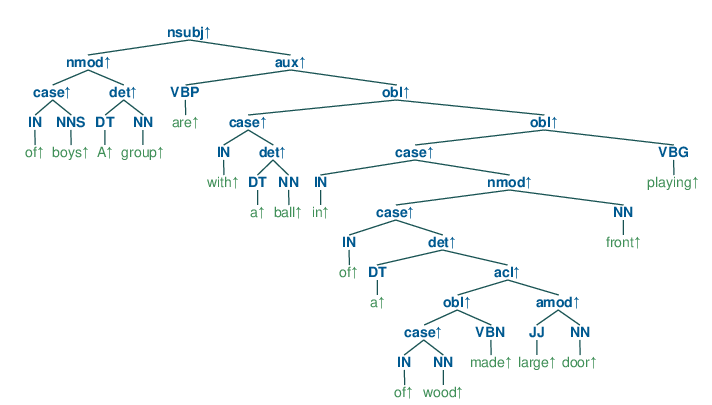

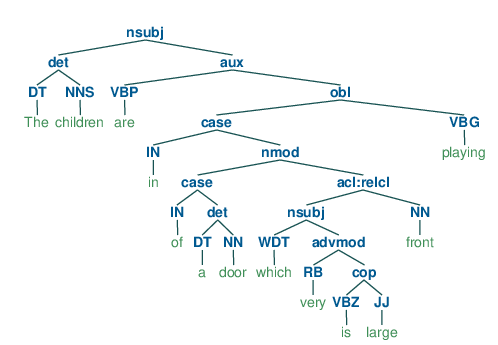

Delet:  case
Delet:  A
Delet:  case
Delet:  a
Delet:  case
Delet:  case
Delet:  a
Delet:  obl
Delet:  case
Delet:  large
('boys are playing with a ball in front of a large door made of wood', tensor(0.6101))
('group are playing with a ball in front of a large door made of wood', tensor(0.5209))
('group are playing with a ball in front of a large door made of wood', tensor(0.5209))
('group of boys are playing with a ball in front of a large door made of wood', tensor(0.5942))
('group of boys are playing with a ball in front of a large door made of wood', tensor(0.5942))
('A group of boys are playing in front of a large door made of wood', tensor(0.7181))
('A group of boys are playing in front of a large door made of wood', tensor(0.7181))
('A group of boys are playing with ball in front of a large door made of wood', tensor(0.5997))
('A group of boys are playing with ball in front of a large door made of wood', tensor(0.5997))
('A group of boys are playing with a ball', tensor(0.4197))


In [142]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

up = ["A group of boys are playing with a ball, in front of a large door made of wood"]
up_h = [ entail_hypo[71]]

annotations = []
phrasalGenerator = PhrasalGenerator()
pipeline = PolarizationPipeline(verbose=0)
for i in range(len(up)):
    premise = up[i]
    hypothesis = up_h[i]
    premise = phrasalGenerator.preprocess(premise)
    hypothesis = phrasalGenerator.preprocess(hypothesis)

    tokenized = tokenizer(premise).sentences[0].words
    tokens = [tok.text for tok in tokenized]

    print("\n====================================")
    print("\nInit Premise: " + premise)
    print("\nHypothesis: " + hypothesis)

    h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
    h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
    pipeline.modify_replacement(h_tree, replaced)
    phrases = {} 
    collect_modifiers(h_tree, phrases, mod_type="NN")
    collect_modifiers(h_tree, phrases, mod_type="VB")
    annotation = pipeline.single_polarization(premise)
    
    phrasalGenerator.kb = phrases
    phrasalGenerator.hypothesis = hypothesis.replace(',', '')
    pp.pprint(phrasalGenerator.kb)
    
    polarized = pipeline.postprocess(annotation['polarized_tree'], {})
    btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btreeViz) 

    polarized = pipeline.postprocess(h_tree, {})
    btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btreeViz)
    
    phrasalGenerator.deptree_generate(
        annotation['polarized_tree'], 
        annotation['annotated'], tokens)

    for gen_tree in phrasalGenerator.tree_log:
        #leaves = gen_tree[0].sorted_leaves().popkeys()
        #sentence = ' '.join([x[0] for x in leaves])
        print((gen_tree[1], gen_tree[2]))

    print(*phrasalGenerator.sent_log, sep="\n")
    print(phrasalGenerator.stop_critarion)

In [ ]:
inference_sts("A yellow dog is sleeping", "A dog is sleeping")

## 5. Lexical Monotonicity Inference

In [134]:
from nltk.stem import WordNetLemmatizer 

import wordnet
from wordnet import get_word_sets
import importlib
importlib.reload(wordnet)

class LexicalGenerator:
    def __init__(self):
        self.deptree = None
        self.hypothesis = ""
        self.tree_log = []
        self.sentence_base = set()
        self.anti_tree_log = []
        self.polar_log = []
        self.replacement_log = []
        self.stop_critarion = False
        self.key_tokens = [
            'NN','NNS','NNP','NNPS','VBD',
            'VBG','VBN','VBZ','VB',"JJ"]

        self.propers = ["someone", "something", "somewhere"]
        self.memory = {}

        self.quantifiers = {}
        self.lemmatizer = WordNetLemmatizer() 
        with open('quantifier.json', 'r') as quants:
            quantifier_data = json.load(quants)
            for quantifier in quantifier_data:
                self.quantifiers[quantifier['word']] = quantifier

    def deptree_generate(self, tree):
        self.replacement_log = []
        self.sentence_base = set()
        self.tree_log = []
        self.anti_tree_log = []
        self.stop_critarion = False
        self.deptree = tree.copy()
        self.generate(self.deptree)

    def generate(self, tree):
        if tree is None or self.stop_critarion:
            return
        if tree.pos is not None and not tree.val in self.hypothesis: 
            backup = copy(tree.val)
            if tree.pos == "NNP" and tree.mark == "+":
                for word in self.propers:
                    if word in self.hypothesis_tokens:
                        tree.val = word
                        self.save_tree()
                        self.replacement_log.append(
                            "{} => {}".format(backup, word))
                        tree.val = backup

            if tree.pos in self.key_tokens:
                if tree.val in self.memory:
                    hyper, hypo, syn, ant = self.memory[tree.val]
                else:
                    hyper, hypo, syn, ant = get_word_sets(
                        self.lemmatizer.lemmatize(tree.val))
                    self.memory[tree.val] = (hyper, hypo, syn, ant)
                print('s', syn)
                #print(tree.val, tree.mark, hyper)

                for lex in syn.keys():
                    lex_ls = lex.split(' ')
                    for key in lex_ls:
                        #print(key)
                        #print(self.hypothesis_tokens)
                        if not ign_words.get(key,0):
                            for tok in self.hypothesis_tokens:
                                if tok in key or key in tok:
                                    tree.val = tok
                                    self.save_tree()
                                    self.replacement_log.append(
                                        "{} => {}".format(backup, tok))
                tree.val = backup

                for lex in ant.keys():
                    lex_ls = lex.split(' ')
                    for key in lex_ls:
                        #print(key)
                        #print(self.hypothesis_tokens)
                        if not ign_words.get(key,0):
                            for tok in self.hypothesis_tokens:
                                if tok in key or key in tok:
                                    tree.val = tok
                                    self.save_tree(entail=False)
                                    self.replacement_log.append(
                                        "{} => {}".format(backup, tok))
                tree.val = backup

                if tree.mark == "+":             
                    for lex in hyper.keys():
                        
                        lex_ls = lex.split(' ')
                        for key in lex_ls:
                            #print(key)
                            #print(self.hypothesis_tokens)
                            if not ign_words.get(key,0):
                                for tok in self.hypothesis_tokens:
                                    if tok in key or key in tok:
                                        print(tok, " ", key)
                                        tree.val = tok
                                        self.save_tree()
                                        self.replacement_log.append(
                                            "{} => {}".format(backup, tok))
                    tree.val = backup

                if tree.mark == "-":
                    for lex in hypo.keys():
                        lex_ls = lex.split(' ')
                        for key in lex_ls:
                            #print(key)
                            #print(self.hypothesis_tokens)
                            if not ign_words.get(key,0):
                                for tok in self.hypothesis_tokens:
                                    if tok in key or key in tok:
                                        tree.val = tok
                                        self.save_tree()
                                        self.replacement_log.append(
                                            "{} => {}".format(backup, tok))
                    tree.val = backup
            
        elif tree.val == "det":
            backup = tree.left.val
            backup_mark = tree.right.mark
            kb = self.quantifiers.get(tree.left.val.lower(), {})
            if len(kb) > 0:

                for word in kb["="]:
                    tree.left.val = word
                    detType = det_type(tree.left.val)
                    if detType is None:
                        detType = "det:exist"
                    tree.left.mark = det_mark[detType]
                    self.save_tree()
                    self.replacement_log.append(
                        "{} => {}".format(backup, word))
                tree.left.val = backup
                tree.left.mark = backup_mark

                if tree.left.mark == "+":
                    for word in kb["<"]:
                        if word in self.hypothesis:
                            tree.left.val = word
                            detType = det_type(tree.left.val)
                            if detType is None:
                                detType = "det:exist"
                            tree.left.mark = det_mark[detType]
                            self.save_tree()
                            self.replacement_log.append(
                                "{} => {}".format(backup, word))
                    tree.left.val = backup
                    tree.left.mark = backup_mark
                
                if tree.left.mark == "-":
                    for word in kb[">"]:
                        if word in self.hypothesis:
                            tree.left.val = word
                            if detType is None:
                                detType = "det:exist"
                            tree.left.mark = det_mark[detType]
                            self.save_tree()
                            self.replacement_log.append(
                                "{} => {}".format(backup, word))
                    tree.left.val = backup
                    tree.left.mark = backup_mark
        
        if tree.left != "N":
            self.generate(tree.left)
        if tree.right != "N":
            self.generate(tree.right)

    def save_tree(self, entail=True):
        leaves = self.deptree.sorted_leaves().popkeys()
        tree_copy = self.deptree.copy()
     
        sentence = ' '.join([x[0] for x in leaves])
        
        if not sentence in self.sentence_base:
            self.sentence_base.add(sentence)
        else:
            return
        
        if sentence.lower() == self.hypothesis.lower():
            self.stop_critarion = True
            if entail:
                self.tree_log = []
                self.tree_log.append((tree_copy, sentence, 1.0))
            else:
                self.anti_tree_log = []
                self.anti_tree_log.append((tree_copy, sentence, 1.0))
            return
        
        similarity = inference_sts([sentence], [self.hypothesis])
        print(sentence, similarity)
        if entail:
            self.tree_log.append((tree_copy, sentence, similarity))
        else:
            self.anti_tree_log.append((tree_copy, sentence, similarity))
        if similarity > 0.97:
            self.stop_critarion = True
            if entail:
                self.tree_log = []
                self.tree_log.append((tree_copy, sentence, similarity))
            else:
                self.anti_tree_log = []
                self.anti_tree_log.append((tree_copy, sentence, similarity))
            return

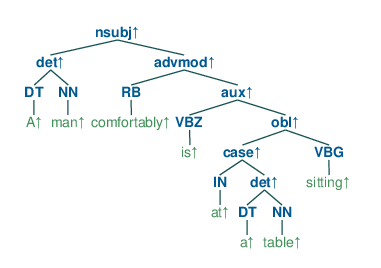

some man is sitting comfortably at a table tensor(0.8207)
an man is sitting comfortably at a table tensor(0.8228)
one man is sitting comfortably at a table tensor(0.7950)
s {'man': 1, 'adult male': 1, 'serviceman': 1, 'military man': 1, 'military personnel': 1, 'homo': 1, 'human being': 1, 'human': 1, 'valet': 1, 'valet de chambre': 1, 'gentleman': 1, "gentleman's gentleman": 1, 'Man': 1, 'Isle of Man': 1, 'piece': 1, 'world': 1, 'human race': 1, 'humanity': 1, 'humankind': 1, 'human beings': 1, 'humans': 1, 'mankind': 1}
A person is sitting comfortably at a table tensor(0.9982)
person   person
person   person
('A person is sitting comfortably at a table', tensor(0.9982))
['A => some', 'A => an', 'A => one', 'man => person', 'man => person', 'man => person']
True


In [123]:
from tqdm import tqdm

sentences = ["A man is sitting comfortably at a table"]
hypotheses = ["A person is sitting comfortably at the table"]

pipeline = PolarizationPipeline(verbose=0)
lexicalGenerator = LexicalGenerator()
phrasalGenerator = PhrasalGenerator()

for premise, hypothesis in zip(sentences, hypotheses):
    premise = phrasalGenerator.preprocess(premise)
    hypothesis = phrasalGenerator.preprocess(hypothesis)

    h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
    #h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
    #pipeline.modify_replacement(h_tree, replaced)
    key_tokens = set()
    for word in h_parsed[2]:
        pos = h_parsed[2][word][1]
        if 'NN' in pos or 'JJ' in pos or 'VB' in pos:
            if(not ign_words.get(h_parsed[2][word][0],0)):
                key_tokens.add(h_parsed[2][word][0])

    #print("\n====================================")
    #print("\nInit Premise: " + premise)
    #print("\nHypothesis: " + hypothesis)

    #tokenized = tokenizer(hypothesis).sentences[0].words
    #tokens = {} 
    #lemmatizer = WordNetLemmatizer() 
    #for tok in tokenized:
    #    tokens[lemmatizer.lemmatize(tok.text)] = tok.text
    lexicalGenerator.hypothesis_tokens = key_tokens

    annotation = pipeline.single_polarization(premise)
    polarized = pipeline.postprocess(annotation['polarized_tree'], {})
    btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btreeViz) 

    lexicalGenerator.hypothesis = hypothesis.replace(',', '')
    lexicalGenerator.deptree_generate(annotation['polarized_tree'])
    
    for gen_tree in lexicalGenerator.tree_log:
        print((gen_tree[1], gen_tree[2]))
    for anti_tree in lexicalGenerator.anti_tree_log:
        print((anti_tree[1], anti_tree[2]))

    print(lexicalGenerator.replacement_log)
    print(lexicalGenerator.stop_critarion)

In [11]:
MED_upward = []
MED_upward_hypo = []
MED_downward = []
MED_downward_hypo = []

with open("../data/MED/upward.txt") as upward_med:
    lines = upward_med.readlines()
    for i in range(len(lines) // 4):
        MED_upward.append(lines[i*4+1])
        MED_upward_hypo.append(lines[i*4+2])

with open("../data/MED/downward.txt") as donward_med:
    lines = donward_med.readlines()
    for i in range(len(lines) // 4):
        MED_downward.append(lines[i*4+1])
        MED_downward_hypo.append(lines[i*4+2])

print(len(MED_upward))
print(len(MED_downward))

458
1738


## 6. Syntactic Variational Inference

In [159]:
from Chunker import Chunker

class SyntacticVariator:
    
    def __init__(self):
        self.chunker = Chunker()
        self.paraphraseTokenizer = paraphraseTokenizer
        self.paraphraseModel = paraphraseModel
        self.replacement_log = []

    def chunking(self, tree):
        return self.chunker.get_chunks_byDepTree(tree)

    def build_pairs(self, chunks1, chunks2):
        chunk_pairs = []
        for chunk1 in chunks1:
            for chunk2 in chunks2:
                if len(set(chunk1.split(' ')).intersection(chunk2.split(' '))) > 0:
                     chunk_pairs.append((chunk1, chunk2))

        return chunk_pairs

    def inference_mrpc(self, seq1, seq2):
        paraphrase = paraphraseTokenizer.encode_plus(
            seq1, seq2, return_tensors="pt")
        #paraphrase.to('cuda')
        logits = paraphraseModel(**paraphrase)[0]
        paraphrase_results = torch.softmax(logits, dim=1).tolist()[0]
        return paraphrase_results[1]

    def phrase_alignment(self, chunk_pairs):
        alignments = []
        for pair in chunk_pairs:
            score = self.inference_mrpc(pair[0], pair[1])
            #print(pair, score)
            if score > 0.80:
                alignments.append(pair)

        return alignments

    def variate(self, P, H, p_tree, h_tree, sent=False):
        self.replacement_log = []
        p_chunks = self.chunking(p_tree)
        h_chunks = self.chunking(h_tree)

     

        if sent:
            p_chunks.append(P)
            h_chunks.append(H)

        chunk_pairs = self.build_pairs(p_chunks, h_chunks)
        alignments = self.phrase_alignment(chunk_pairs)

        #print(*p_chunks, sep="\n")
        #print(*h_chunks, sep="\n")

        variates = set()
        for align in alignments:
            alignList1 = align[1].split(' ')
            if(alignList1[0] == "Somebody"):
                alignList2 = align[0].split(' ')
                var_sentence = P.replace(' '.join(alignList2[1:]), ' '.join(alignList1[1:]))
                self.replacement_log.append(
                        "{} => {}".format(' '.join(alignList2[1:]), ' '.join(alignList1[1:])))
            else:
                var_sentence = P.replace(align[0], align[1])
                self.replacement_log.append(
                        "{} => {}".format(align[0], align[1]))
            
            variates.add(var_sentence)

        return variates
#ie_pred_p = ie_extractor.predict(P)['verbs']
    '''    ie_pred_h = ie_extractor.predict(H)['verbs']

        for verb in ie_pred_p:
            if "ARG" in verb['description']:
                p_chunks.append(fix_info(verb['description'])[0].strip())
                p_chunks.append(verb['verb'] + ' '+ fix_info(verb['description'])[2].strip())

        for verb in ie_pred_h:
            if "ARG" in verb['description']:
                h_chunks.append(fix_info(verb['description'])[0].strip())
                h_chunks.append(verb['verb'] + ' '+ fix_info(verb['description'])[2].strip())'''

In [13]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.structured_prediction

ie_extractor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz")

ModuleNotFoundError: No module named 'allennlp_models'

In [14]:
def fix_info(desc):
    out = desc.replace("[ARG0: ", "")
    out = out.replace("[ARG1: ", "")
    out = out.replace("[V: ", "")
    out = out.replace("]", ",")
    out = out.split(",")
    return out

In [ ]:
ie_pred = ie_extractor.predict("Two men are standing near the water and are holding fishing poles")['verbs']
print(ie_pred)
for verb in ie_pred:
    if "ARG" in verb['description']:
        print(fix_info(verb['description']))

In [21]:
premise = "A laughing child is holding a squirt gun and getting sprayed with water"
hypothesis = "A child is holding a squirt gun"

pipeline = PolarizationPipeline()
syntacticVariator = SyntacticVariator()

h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
pipeline.modify_replacement(h_tree, replaced)
annotation = pipeline.single_polarization(premise)

variates = syntacticVariator.variate(premise, hypothesis, annotation['polarized_tree'],  h_tree, sent=False)
for v in variates:
    similarity = inference_sts([v], [hypothesis])
    print(v, similarity)

A laughing child is holding a is holding a squirt gun and getting sprayed with water tensor(0.7736)
A laughing child is is holding a squirt gun a squirt gun and getting sprayed with water tensor(0.7838)
A laughing child is holding a squirt gun and getting sprayed with water tensor(0.7746)


In [ ]:
syntacticVariator.inference_mrpc("hiking", "are walking")

In [163]:
inference_sts(["is wearing"], ["Somebody is wearing beads that are red"])

tensor(0.3412)

## 7. A* Inference Search Engine

In [160]:
from pqdict import pqdict

class AStarPlanner:
    def __init__(self):    
        self.closed = []                  
        self.entailments = set()
        self.contradictions = set()
        self.hypothesis = ""
        self.h_tree = None

        self.pipeline = PolarizationPipeline()
        self.phrasalGenerator = PhrasalGenerator()
        self.lexicalGenerator = LexicalGenerator()
        self.syntacticVariator = SyntacticVariator() 

    def hypothesis_kb(self):
        self.hypothesis = self.phrasalGenerator.preprocess(self.hypothesis).replace('\n', '')
        h_parsed, replaced = dependency_parse(self.hypothesis, parser="stanza")
        h_tree, _ = self.pipeline.run_binarization(h_parsed, self.hypothesis, {})
        self.pipeline.modify_replacement(h_tree, replaced)
        phrases = {} 
        collect_modifiers(h_tree, phrases, mod_type="NN")
        collect_modifiers(h_tree, phrases, mod_type="VB")
        self.phrasalGenerator.kb = phrases
        key_tokens = set()
        for word in h_parsed[2]:
            pos = h_parsed[2][word][1]
            if 'NN' in pos or 'JJ' in pos or 'VB' in pos:
                if(not ign_words.get(h_parsed[2][word][0],0)):
                    key_tokens.add(h_parsed[2][word][0])
        self.lexicalGenerator.hypothesis_tokens = key_tokens
        self.lexicalGenerator.hypothesis = self.hypothesis.replace(',','')
        self.h_tree = h_tree
        

    def generate_premises(self, start):
        self.entailments.clear()
        self.contradictions.clear()

        # Polarization from Udeo2Mono
        start = self.phrasalGenerator.preprocess(start)
        annotation = self.pipeline.single_polarization(start)

        # Monotonicity-based Phrasl Inference
        self.phrasalGenerator.hypothesis = self.hypothesis.replace(',', '')

        tokenized = tokenizer(start).sentences[0].words
        tokens = [tok.text for tok in tokenized]

        self.phrasalGenerator.deptree_generate(
        annotation['polarized_tree'], 
        annotation['annotated'], tokens)
        print("============================")
        
        if self.phrasalGenerator.stop_critarion:
            return True

        for tree in self.phrasalGenerator.tree_log:
            self.entailments.add((tree[1], tree[2]))
        self.entailments |= set(self.phrasalGenerator.sent_log)

        print(*self.entailments, sep="\n")
        

        # Syntactic Vriation
        # Sequence Chunking and Chunk Alignment from roBERTa
        sent_level = False
        if self.current_optimal > 0.93 :
            sent_level = True
        variates = self.syntacticVariator.variate(
            start, 
            self.hypothesis, 
            annotation['polarized_tree'], 
            self.h_tree, sent_level)
        for v in variates:
            similarity = inference_sts([v], [self.hypothesis])
            print(similarity, v)
            if similarity > 0.98:
                return True
            elif similarity > 0.9:
                self.entailments.add((v, similarity))
        print(self.syntacticVariator.replacement_log)

        #TODO: Monotonicity-based Lexical Inference
        print("Generate Lexical Variation")
        #lemmatizer = WordNetLemmatizer() 
        #tokens_dict = {}
        #for tok in tokenized:
        #    tokens_dict[lemmatizer.lemmatize(tok.text)] = tok.text
        #tokens_dict = set()
        #self.lexicalGenerator.hypothesis_tokens = tokens_dict
        self.lexicalGenerator.hypothesis = self.hypothesis.replace(',', '')
        
        self.lexicalGenerator.deptree_generate(annotation['polarized_tree'])
        print(self.lexicalGenerator.replacement_log)
        if self.lexicalGenerator.stop_critarion:
            return True
        for tree in self.lexicalGenerator.tree_log:
            #rint((tree[1], tree[2]))
            self.entailments.add((tree[1], tree[2]))
            

        return False

    def generate(self, start, opened):
        terminate = self.generate_premises(start)
        if terminate:
            return True

        for premise in self.entailments:
            if premise in self.closed:
                continue
            cost = premise[1]
            if premise[0] not in opened:
                opened[premise[0]] = cost
            if cost < opened[premise[0]]:
                opened[premise[0]] = cost
        return False

    def search(self, premises, hypothesis):
        self.closed = pqdict({})
        self.hypothesis = hypothesis
        premises = premises.replace('\n','')

        self.hypothesis_kb()
        self.phrasalGenerator.hypothesis = self.hypothesis
        self.lexicalGenerator.hypothesis = self.hypothesis

        open_lists = pqdict({}, reverse=True)
        open_lists[premises] = inference_sts([premises], [hypothesis])

        hop = 0
        top_k = 2

        while open_lists:
            for _ in range(top_k):
                if len(open_lists) > 0:
                    optimal = open_lists.popitem()
                    self.current_optimal = optimal[1]
                    self.closed[optimal] = len(self.closed) + 1
                    print("Optimal: ", optimal)
                    goal_found = self.generate(optimal[0], open_lists)
                    if goal_found:
                        optimal = open_lists.popitem()
                        self.closed[optimal] = len(self.closed) + 1
                        print("Optimal: ", optimal)
                        self.closed[(self.hypothesis, 1.0)] = len(self.closed) + 1
                        return True
                else: break   
            hop += 1
            if hop > 5: break

In [161]:
planner = AStarPlanner()

In [144]:
from tqdm import tqdm
entail_p = []
entail_hypo = []
with open("../data/SICk/entail.txt") as upward_med:
    lines = upward_med.readlines()
    for i in range(len(lines) // 3):
        entail_p.append(lines[i*3])
        entail_hypo.append(lines[i*3+1])

print(len(entail_p))

with open("./generation_log_SICK.txt", 'w') as generate_log:
    for i in tqdm(range(0, len(entail_p))):
        premise = entail_p[i].replace('\n', '')
        hypothesis = entail_hypo[i].replace('\n', '')
        try:
            entail = planner.search(premise, hypothesis)
            if not entail:
                generate_log.write("\nID: " + str(i))
                generate_log.write("\nPremise: " + premise)
                generate_log.write("\nHypothesis: " + hypothesis)
                generate_log.write('\n')
        except:
            generate_log.write("\nID: " + str(i))
            generate_log.write("\nPremise: " + premise)
            generate_log.write("\nHypothesis: " + hypothesis)
            generate_log.write('\n')

        #print(*planner.closed, sep=" =>\n")

1414


In [ ]:
entail = planner.search("Two people wearing snowsuits are on the ground making snow angels",
        "Two people in snowsuits are lying in the snow and making snow angels")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("Tambourines are being played by a group of children", 
             "A group of children is playing tambourines")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("A family is watching a little boy who is hitting a baseball", 
             "A child is hitting a baseball")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("You know that some life changing actions must be taken when grandma reacts with the sad emoji", "You know that some actions must be taken when grandma reacts with the sad emoji")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("A black and a white dog are joyfully running on the grass", 
             "A dog, which has a black coat, and a white dog are running on the grass")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("A group of boys are playing with a ball, in front of a large door made of wood", 
             "The children are playing in front of a large door")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("A man with a red helmet is riding a blue motorcycle down the road", 
             "A motorcyclist is riding a motorbike along a roadway")
print(*planner.closed, sep=" =>\n")
print(entail)

In [162]:
entail = planner.search(entail_p[76], entail_hypo[76])
#entail = planner.search("A dog that has a black and white coat is trotting through shallow water", 
#             "A dog that has a white and black colored coat is trotting through shallow water.")
print(*planner.closed, sep=" =>\n")
print(entail)

Optimal:  ('A young lady with light brown hair is wearing a red necklace, a sweatshirt and earrings and is smiling', tensor(0.5387))
('A young lady with light brown hair is wearing a red necklace sweatshirt earrings and is smiling', tensor(0.5326))
('A young lady with brown hair is wearing a red necklace a sweatshirt and earrings and is smiling', tensor(0.4895))
('A young lady with light brown hair is wearing a necklace a sweatshirt and earrings and is smiling', tensor(0.4437))
('young lady with light brown hair is wearing a red necklace a sweatshirt and earrings and is smiling', tensor(0.5001))
('A young lady with light brown hair is wearing a a sweatshirt earrings and is smiling', tensor(0.4188))
('A young lady with light brown is wearing a red necklace a sweatshirt and earrings and is smiling', tensor(0.5039))
('A young lady with light brown hair is wearing red necklace a sweatshirt earrings and is smiling', tensor(0.5245))
('A young lady with light brown hair is wearing a red neckl

('A young lady with light brown hair is wearing a red necklace a earrings', tensor(0.6950))
('A young lady with light brown hair is wearing a red necklace sweatshirt earrings', tensor(0.6284))
('A young lady with light brown hair is wearing red necklace a sweatshirt and earrings', tensor(0.6206))
('A young lady with light brown is wearing a red necklace a sweatshirt and earrings', tensor(0.6142))
('young lady with light brown hair is wearing a red necklace a sweatshirt and earrings', tensor(0.6063))
('A young lady with light brown hair is wearing a necklace a sweatshirt and earrings', tensor(0.5321))
('A young lady with light brown hair is wearing a necklace a sweatshirt and earrings', tensor(0.5321))
('A young lady with light brown hair is wearing red necklace a sweatshirt and earrings', tensor(0.6206))
('A young lady with light brown hair is wearing a red necklace sweatshirt earrings', tensor(0.6284))
('A young lady with light brown is wearing a red necklace a sweatshirt and earrings

tensor(0.6950) A young lady with light brown hair is wearing a red necklace a earrings
tensor(0.7118) A young lady with light brown hair is wearing beads that are red a red necklace a earrings
tensor(0.8222) A teenage girl with light brown hair is wearing a red necklace a earrings
tensor(0.7088) A young lady with light brown hair is is wearing beads that are red a red necklace a earrings
['is wearing => is wearing', 'wearing => is wearing beads that are red', 'A young lady => A teenage girl', 'Somebody is wearing => is wearing', 'is wearing => is wearing beads that are red']
Generate Lexical Variation
s {'brown': 1, 'brownness': 1, 'Brown': 1, 'Robert Brown': 1, 'John Brown': 1, 'Brown University': 1, 'embrown': 1, 'brownish': 1, 'chocolate-brown': 1, 'dark-brown': 1, 'browned': 1}
red   colored
A young lady with light red hair is wearing a red necklace a earrings tensor(0.7178)
s {'light': 1, 'visible light': 1, 'visible radiation': 1, 'light source': 1, 'luminosity': 1, 'brightness':

an young lady is wearing a red necklace earrings tensor(0.7578)
one young lady is wearing a red necklace earrings tensor(0.7550)
s {'young': 1, 'offspring': 1, 'Young': 1, 'Loretta Young': 1, 'Whitney Young': 1, 'Whitney Moore Young Jr.': 1, 'Thomas Young': 1, 'Pres Young': 1, 'Lester Willis Young': 1, 'Edward Young': 1, 'Cy Young': 1, 'Danton True Young': 1, 'Brigham Young': 1, 'youth': 1, 'immature': 1, 'new': 1, 'youthful': 1, 'vernal': 1, 'unseasoned': 1, 'untested': 1, 'untried': 1}
A teenage lady is wearing a red necklace earrings tensor(0.8850)
teenage   age
teenage   age
s {'lady': 1, 'dame': 1, 'madam': 1, "ma'am": 1, 'gentlewoman': 1, 'Lady': 1, 'noblewoman': 1, 'peeress': 1}
A young lady is wearing some red necklace earrings tensor(0.7616)
A young lady is wearing an red necklace earrings tensor(0.7595)
A young lady is wearing one red necklace earrings tensor(0.7091)
s {'necklace': 1}
A young lady is wearing a red wearing earrings tensor(0.7323)
wearing   wear
s {'earring': 1

In [ ]:
entail = planner.search("A family is watching a little boy who is hitting a baseball", 
             "A child is hitting a baseball")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("A deer is jumping over a fence", 
             "A deer is jumping a fence")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("A boy is hitting a baseball", 
             "A chil is hitting a baseball")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("A brown dog is attacking another animal in front of the tall man in pants", 
             "A dog is attacking another animal in front of the man in pants")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("A family is watching a little boy who is hitting a baseball", 
             "A family is watching a boy who is hitting a baseball")
print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
entail = planner.search("You can't park in front of my house on weekends.", 
             "You can't park in front of my large house on weekends.")

print(*planner.closed, sep=" =>\n")
print(entail)

In [ ]:
from tqdm import tqdm

annotations = []
with open("./generation_log_upward.txt", 'w') as generate_log:
    phrasalGenerator = PhrasalGenerator()
    pipeline = PolarizationPipeline(verbose=0)
    for i in tqdm(range(0, 500)):
        premise = MED_none[i].replace('\n', '')
        hypothesis = MED_none_hypo[i].replace('\n', '')
        premise = phrasalGenerator.preprocess(premise)
        hypothesis = phrasalGenerator.preprocess(hypothesis)

        tokenized = tokenizer(premise).sentences[0].words
        tokens = [tok.text for tok in tokenized]

        try:
            h_parsed, replaced = dependency_parse(hypothesis, parser="stanza")
            h_tree, _ = pipeline.run_binarization(h_parsed, hypothesis, {})
        except:
            generate_log.write("\nPremise: " + premise)
            generate_log.write("\nHypothesis: " + hypothesis)
            continue
        pipeline.modify_replacement(h_tree, replaced)
        phrases = {} 
        collect_modifiers(h_tree, phrases, mod_type="NN")
        collect_modifiers(h_tree, phrases, mod_type="VB")

        try:
            annotation = pipeline.single_polarization(premise)
        except:
            #generate_log.write("\nPremise: " + premise)
            #generate_log.write("\nHypothesis: " + hypothesis)
            continue
    
        phrasalGenerator.kb = phrases
        #print(phrasalGenerator.kb)
        phrasalGenerator.hypothesis = hypothesis.replace(',', '')
        
        phrasalGenerator.deptree_generate(
            annotation['polarized_tree'], 
            annotation['annotated'], 
            tokens)

        # for gen_tree in phrasalGenerator.tree_log:
        #    leaves = gen_tree[0].sorted_leaves().popkeys()
        #    sentence = ' '.join([x[0] for x in leaves])
        #    print((sentence, gen_tree[1]))
            
        if phrasalGenerator.stop_critarion:
            generate_log.write("\nID: " + str(i))
            generate_log.write("\nPremise: " + premise)
            generate_log.write("\nHypothesis: " + hypothesis)
            #print("\nPremise: " + premise)
            #print("\nHypothesis: " + hypothesis)
            #print(*phrasalGenerator.sent_log, sep="\n")
            #generate_log.writelines(phrasalGenerator.sent_log)
            generate_log.write('\n')